In [41]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from typing import TypedDict, Literal
from dotenv import load_dotenv

In [42]:
load_dotenv()

True

In [43]:
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [44]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negetive"] = Field(
        description="Sentiment of the review"
    )

In [ ]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(
        description="The category of issue mentioned in the review"
    )
    tone: Literal["angry", "frustrated", "disappointed", "clam"] = Field(
        description="The emotional tone expressed by the user"
    )
    urgency: Literal["low", "medium", "high"] = Field(
        description="How urgent or critical the issue appears to be"
    )

In [46]:
structured_model = model.with_structured_output(SentimentSchema)

In [47]:
diagnosis_structured_model = model.with_structured_output(DiagnosisSchema)

In [48]:
# prompt = "What is the sentiment of the following review \n The software is very bad"
# structured_model.invoke(prompt).sentiment

In [49]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negetive"]
    diagnosis: dict
    response: str

In [50]:
def find_sentiment(state: ReviewState):
    prompt = f"For the following review find out the sentiment \n {state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment
    return {"sentiment": sentiment}

In [51]:
def check_sentiment(
    state: ReviewState,
) -> Literal["positive_response", "run_diagnosis"]:
    if state["sentiment"] == "positive":
        return "positive_response"
    else:
        return "run_diagnosis"

In [52]:
def positive_response(state: ReviewState):
    prompt = f"Write a warm thank you message in response to this review: \n\n {state['review']} \n\n Also, kindly ask the user to leave feedbck on our website."
    response = model.invoke(prompt).content
    return {"response": response}

In [ ]:
def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this negetive review: \n\n {state["review"]} \n
    Return issue_type, tone and urgency
    """
    response = diagnosis_structured_model.invoke(prompt)
    return {"diagnosis": response.model_dump()}

In [ ]:
def negetive_response(state: ReviewState):
    diagnosis = state["diagnosis"]
    prompt = f"""
    You are a support assistant.
    The user had a {diagnosis["issue_type"]} issue, sounded {diagnosis["tone"]}, and marked urgency as {diagnosis["urgency"]}.
    Write an empathetic, helpfull resolution message.
    """
    response = model.invoke(prompt).content
    return {"response": response}

In [55]:
graph = StateGraph(ReviewState)

graph.add_node("find_sentiment", find_sentiment)
graph.add_node("positive_response", positive_response)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negetive_response", negetive_response)


graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment", check_sentiment)
graph.add_edge("positive_response", END)
graph.add_edge("run_diagnosis", "negetive_response")
graph.add_edge("negetive_response", END)

workflow = graph.compile()

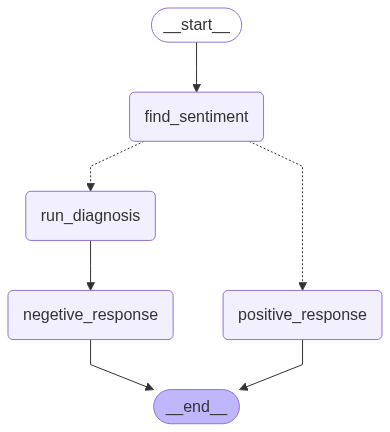

In [56]:
workflow

In [ ]:
initial_state = {
    "review": """I've been using FocusTrackr, and it's honestly transformed how I manage my day. The clean UI, seamless task syncing, and intelligent reminders help me stay focused without feeling overwhelmed.

What stands out the most is the AI-powered distraction detector, which nudges me gently when I drift off-task—brilliant! Also, the weekly productivity reports are super insightful and helped me cut down my screen time by 30%.

Support is responsive, and new features roll out frequently. It’s clear that the dev team listens to users."""
}

workflow.invoke(initial_state)

{'review': "I've been using FocusTrackr, and it's honestly transformed how I manage my day. The clean UI, seamless task syncing, and intelligent reminders help me stay focused without feeling overwhelmed.\n\nWhat stands out the most is the AI-powered distraction detector, which nudges me gently when I drift off-task—brilliant! Also, the weekly productivity reports are super insightful and helped me cut down my screen time by 30%.\n\nSupport is responsive, and new features roll out frequently. It’s clear that the dev team listens to users.",
 'sentiment': 'positive',
 'response': "Wow, thank you so much for this incredible review! We're absolutely thrilled to hear that FocusTrackr has made such a positive impact on your daily productivity and helped you reduce your screen time by 30% – that's fantastic!  We're especially happy you appreciate the clean UI, seamless syncing, intelligent reminders, and the AI-powered distraction detector.  Hearing that our support team is responsive and th

In [59]:
initial_state = {
    "review": """I had high hopes for FocusTrackr after seeing the landing page and reading the features. But after a week of usage, I’m left disappointed. The UI looks polished, but it’s sluggish and freezes often.

The "AI distraction detection" barely works — it flagged normal usage as distractions and didn’t adapt at all. Also, syncing between devices was buggy; I lost two entire days of task logs.

Support took over 48 hours to reply, and the response felt copy-pasted. For a paid tool, the performance is not up to the mark."""
}

workflow.invoke(initial_state)

{'review': 'I had high hopes for FocusTrackr after seeing the landing page and reading the features. But after a week of usage, I’m left disappointed. The UI looks polished, but it’s sluggish and freezes often.\n\nThe "AI distraction detection" barely works — it flagged normal usage as distractions and didn’t adapt at all. Also, syncing between devices was buggy; I lost two entire days of task logs.\n\nSupport took over 48 hours to reply, and the response felt copy-pasted. For a paid tool, the performance is not up to the mark.',
 'sentiment': 'negetive',
 'diagnosis': {'issue_type': 'Performance',
  'tone': 'disappointed',
  'urgency': 'medium'},
 'response': "Subject: Following up on your performance issue\n\nHi [User Name],\n\nI'm so sorry to hear you're experiencing performance issues and understand your disappointment.  I want to assure you we're here to help get things running smoothly again.\n\nSince you've marked this as medium urgency, could you please provide me with some mor